# Selling Second Hand Cars # 

## Introduction ## 

This notebook gives an overview of the process used to data extraction and cleaning, as well as the modelling process that underpins the models used in askahseng.com, a web app for generating price predictions and selling probabilities for second hand cars in Singapore. 

## Outline ## 

1. [Data Collection](#collect)
2. [Data Exploration](#explore)
3. [Predicting OMV (Open Market Value)](#omv)
4. [Predicting Value](#value)
5. [Predicting Probability of selling within 7 days](#proba)



In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.sql import text
from dateutil.relativedelta import relativedelta
import re
from private import * 
from train_models import * 

sns.set_style("whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [67]:
engine = create_engine('postgresql://',creator=connect)

In [68]:
cars = get_cars_df()
coe_long =get_coe_df()
cars= clean_cars(cars,coe_long)
cars= impute_mileage(cars)

In [35]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

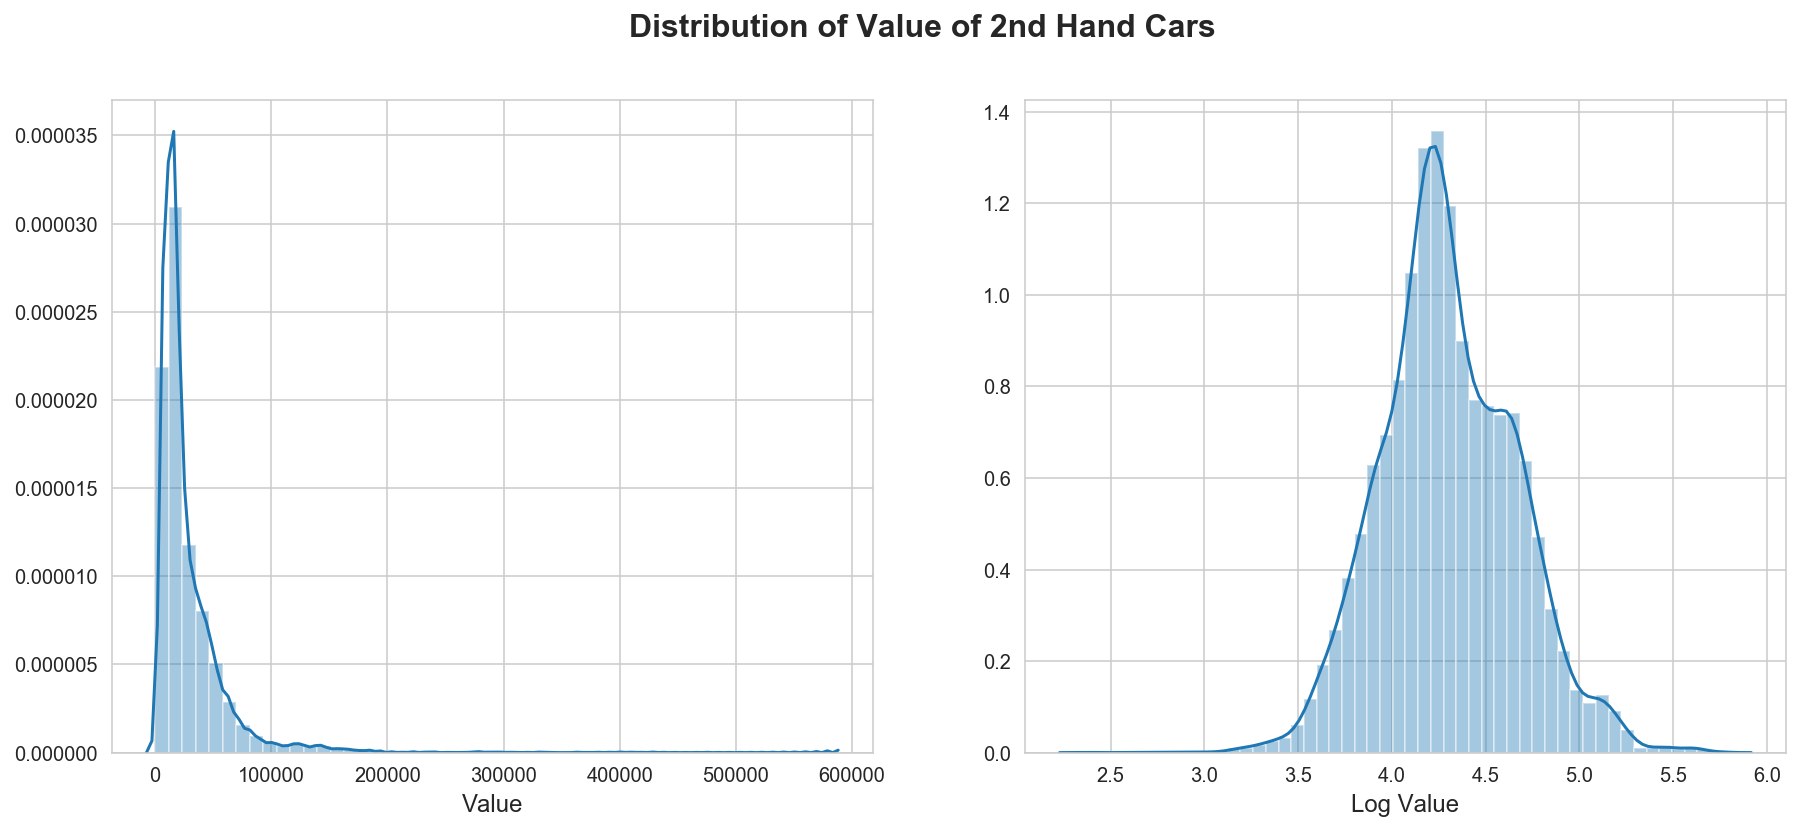

In [36]:
f,ax=plt.subplots(1,2,figsize=(15,6))
sns.distplot(cars['value'],ax=ax[0])
ax[0].set_xlabel('Value',fontsize=12)
sns.distplot(np.log10(cars['value']),ax=ax[1])

ax[1].set_xlabel('Log Value',fontsize=12)
f.suptitle('Distribution of Value of 2nd Hand Cars',fontsize=16,fontweight='bold')
plt.show()

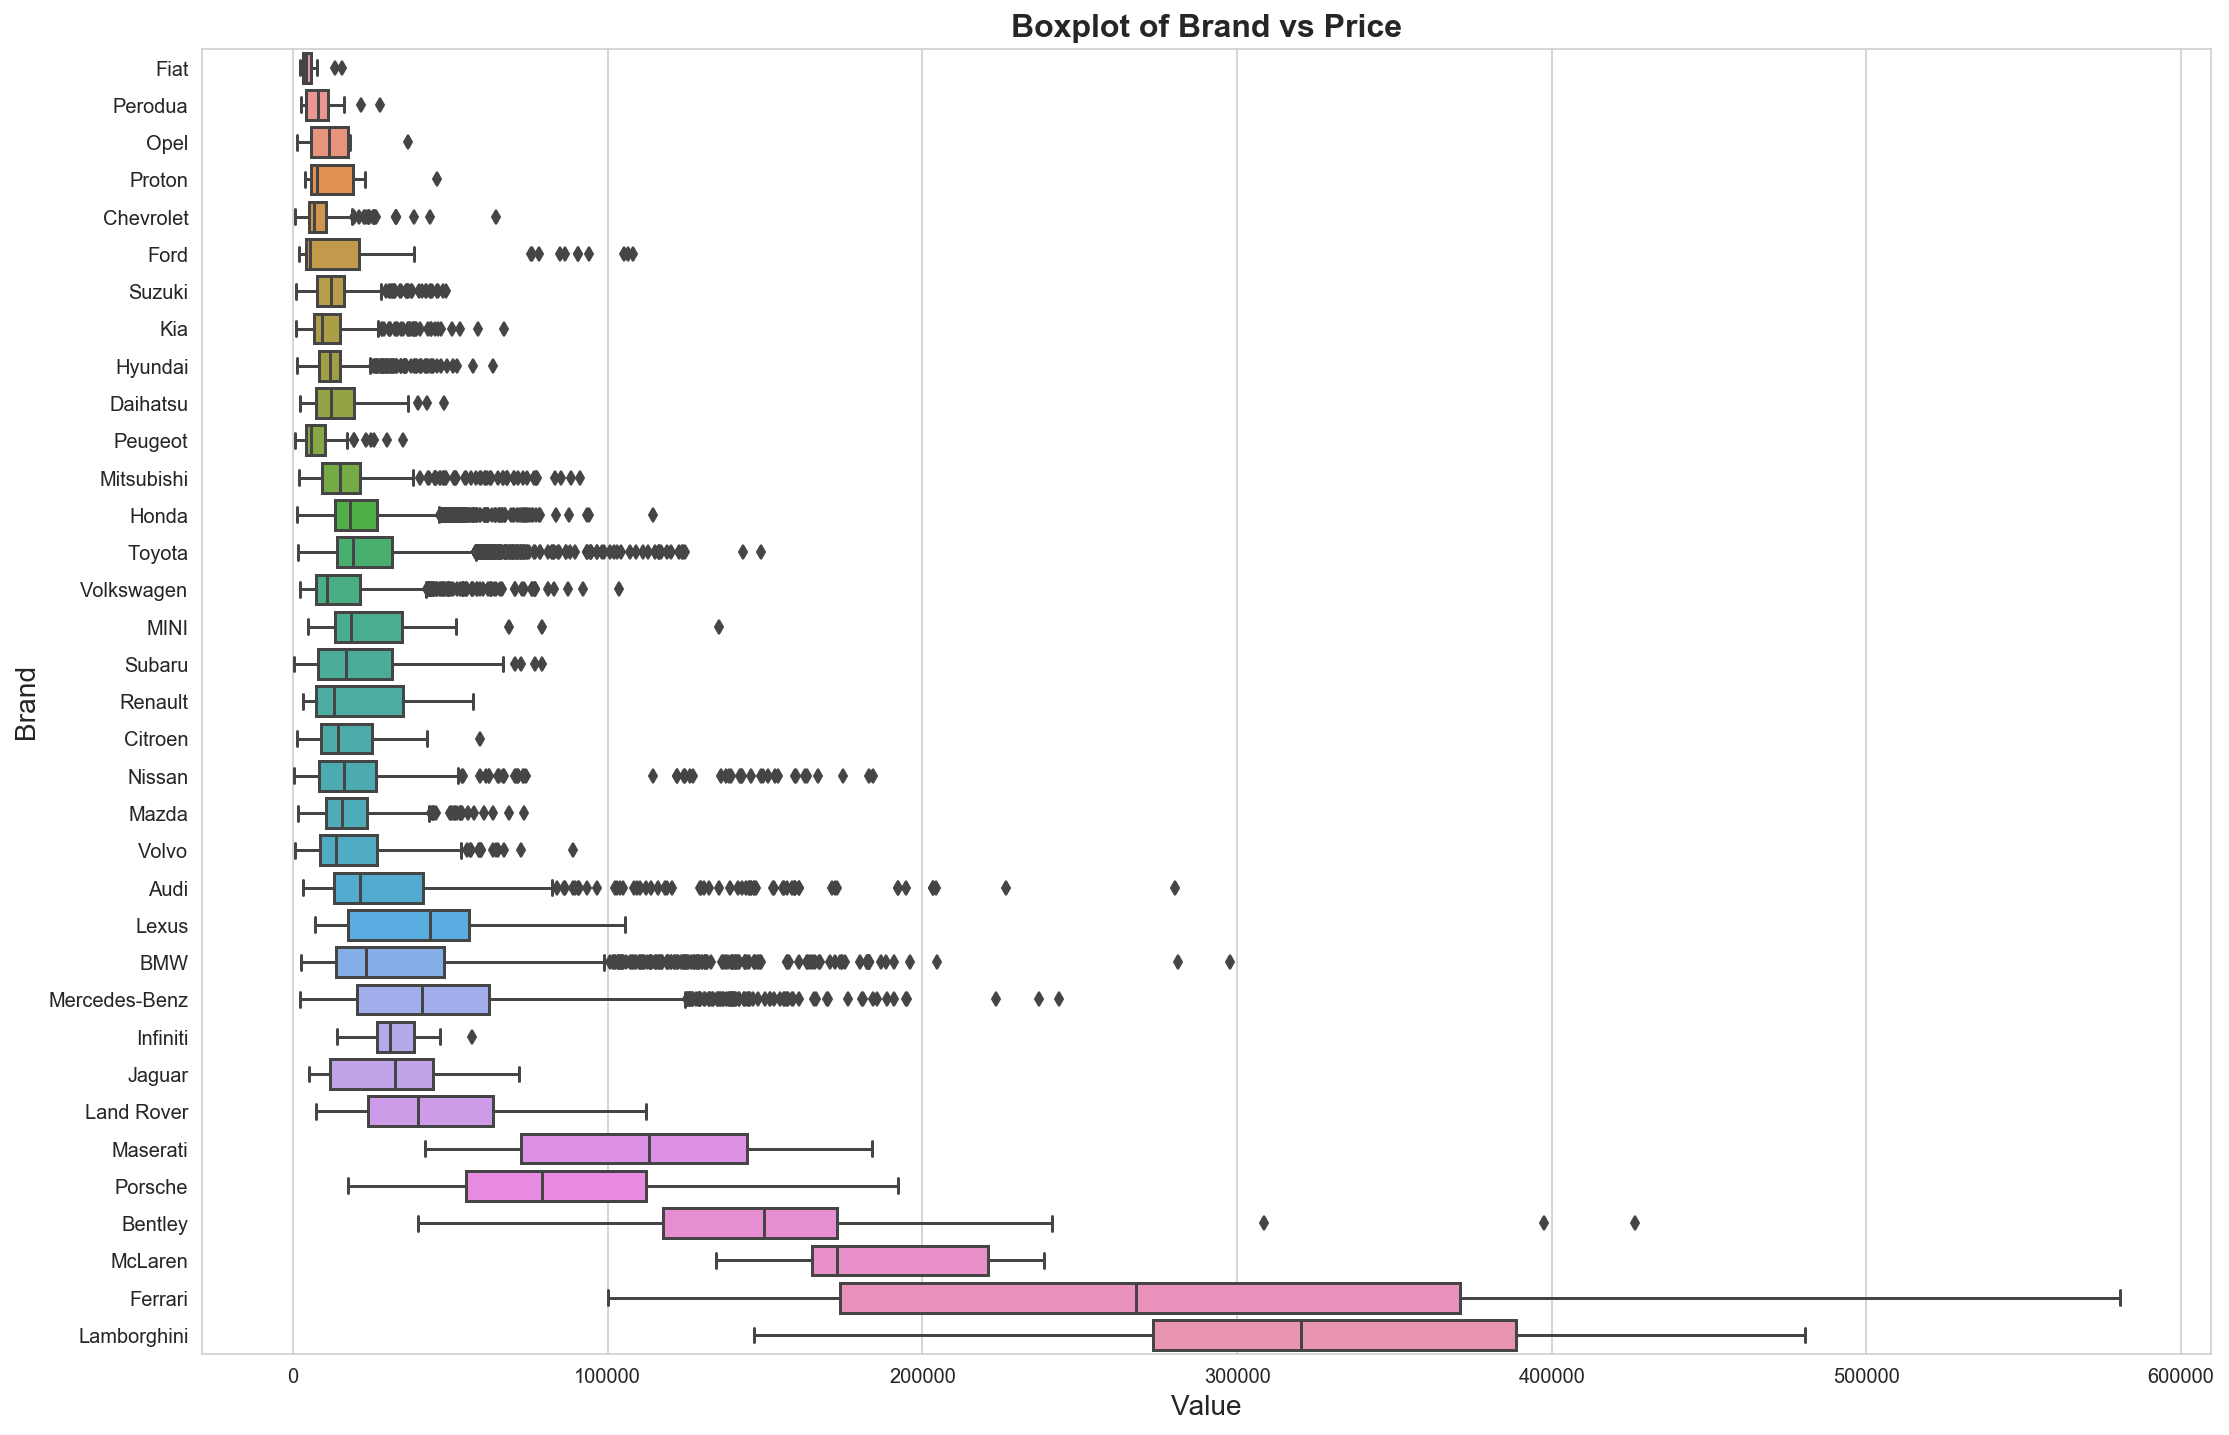

In [37]:
plt.figure(figsize=(18,12))
ax=sns.boxplot(y='brand',x='value',data=cars,orient='h',order=cars['price'].groupby(cars['brand']).median().sort_values(ascending=True).index)
ax.set_ylabel('Brand',fontsize=14)
ax.set_xlabel('Value',fontsize=14)
plt.title('Boxplot of Brand vs Price',fontsize=16,fontweight='bold')
plt.show()

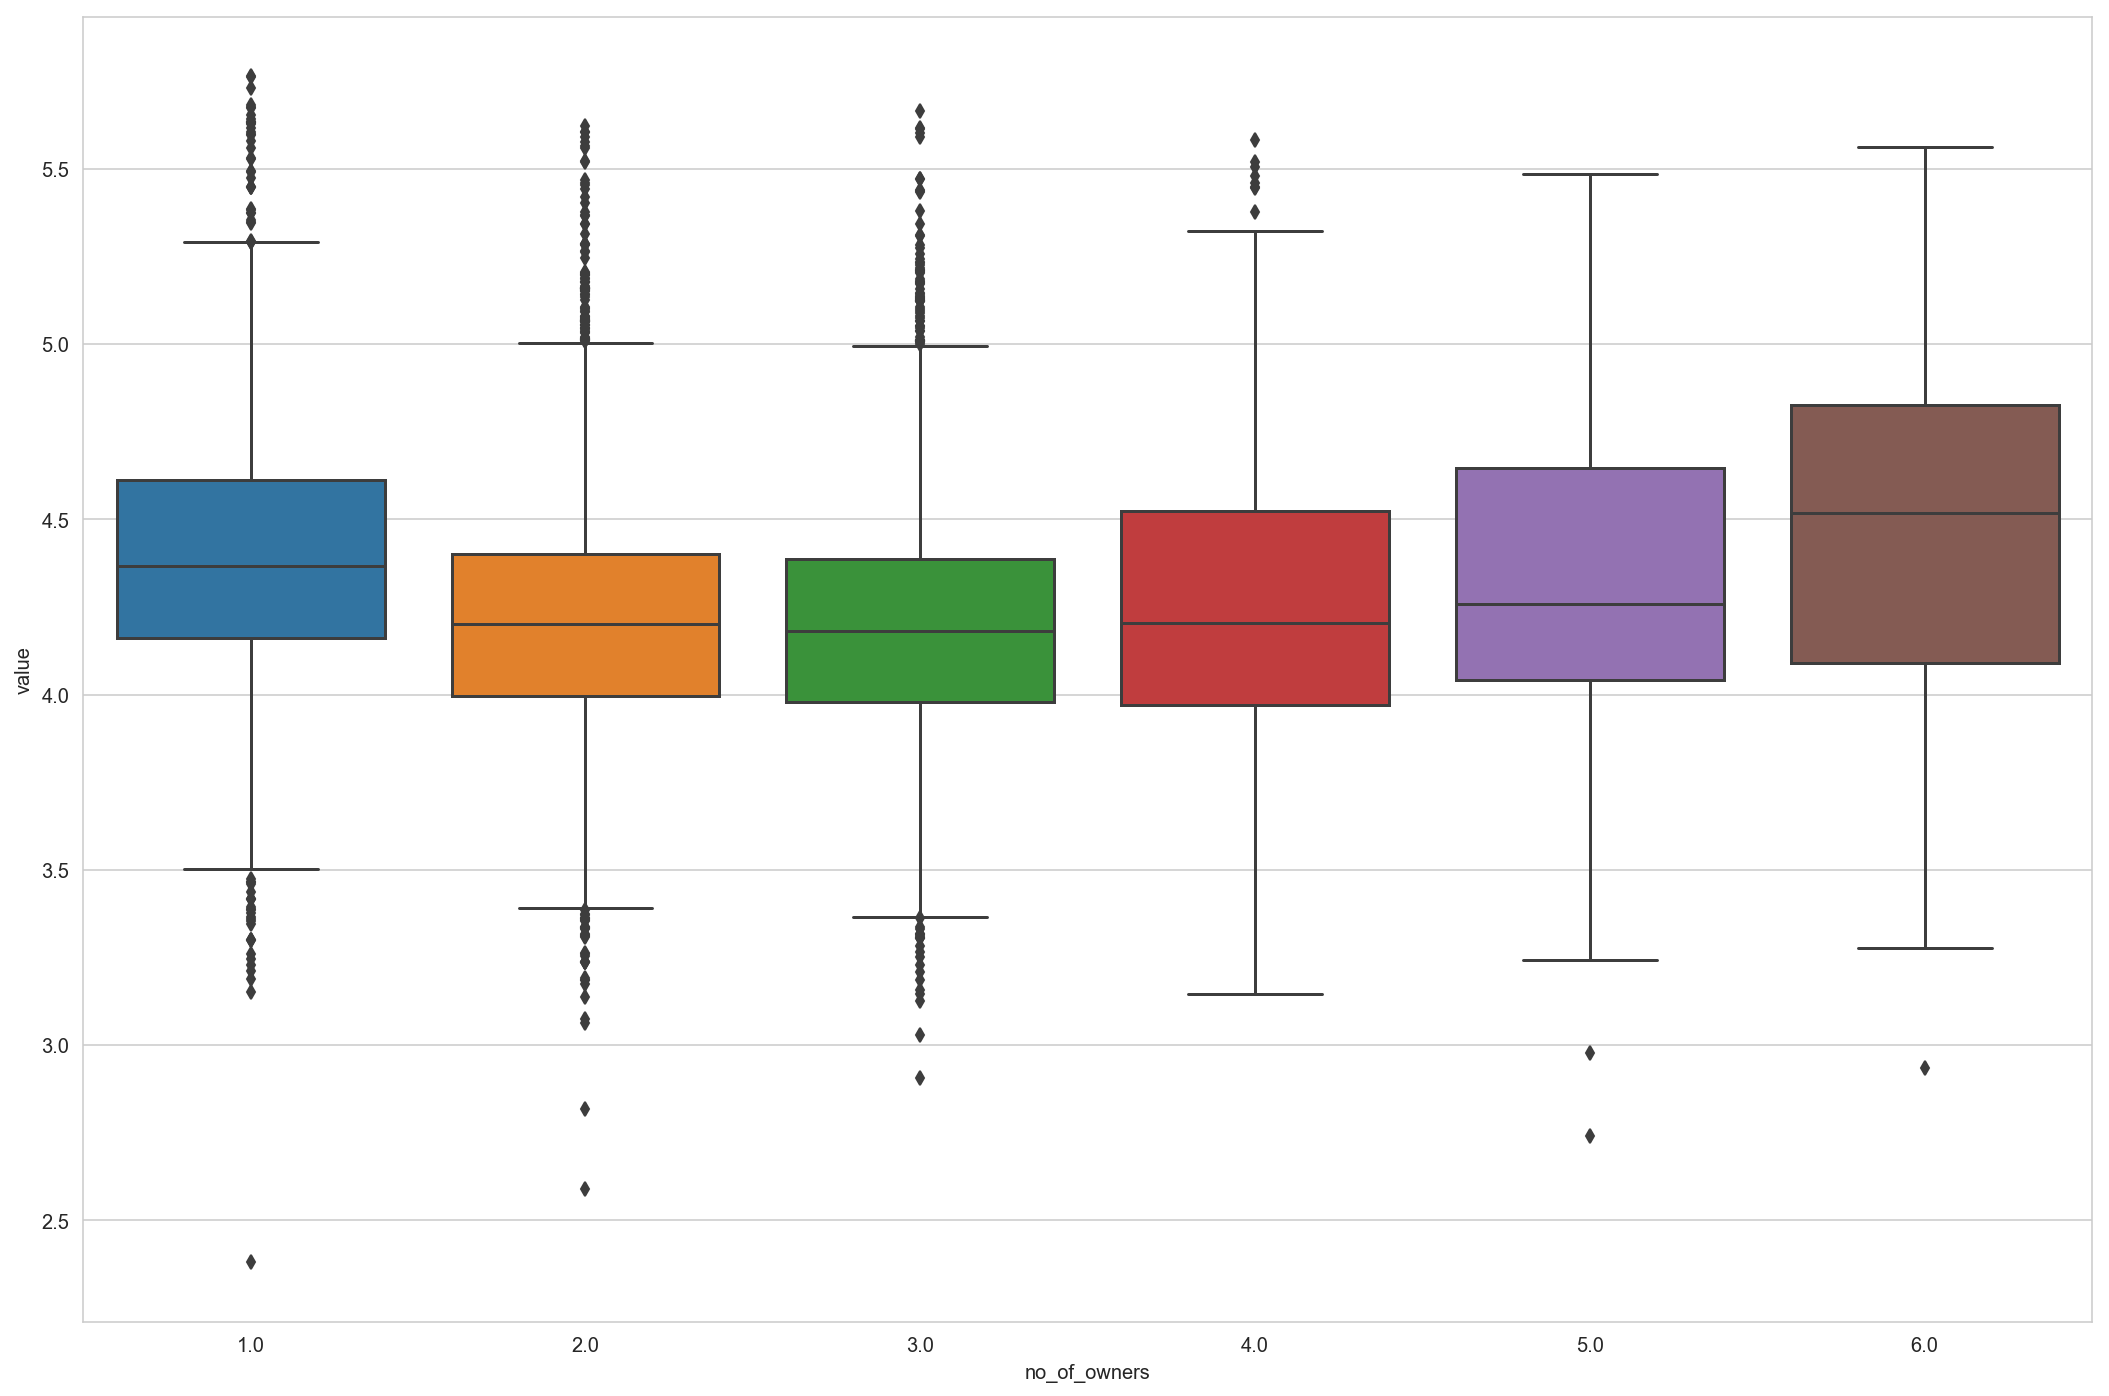

In [38]:
plt.figure(figsize=(18,12))
ax=sns.boxplot(y=np.log10(cars['value']),x='no_of_owners',data=cars)

In [39]:
num_feats=[i for i in list(cars.select_dtypes('number').columns) if i.split('_')[0] != 'is']

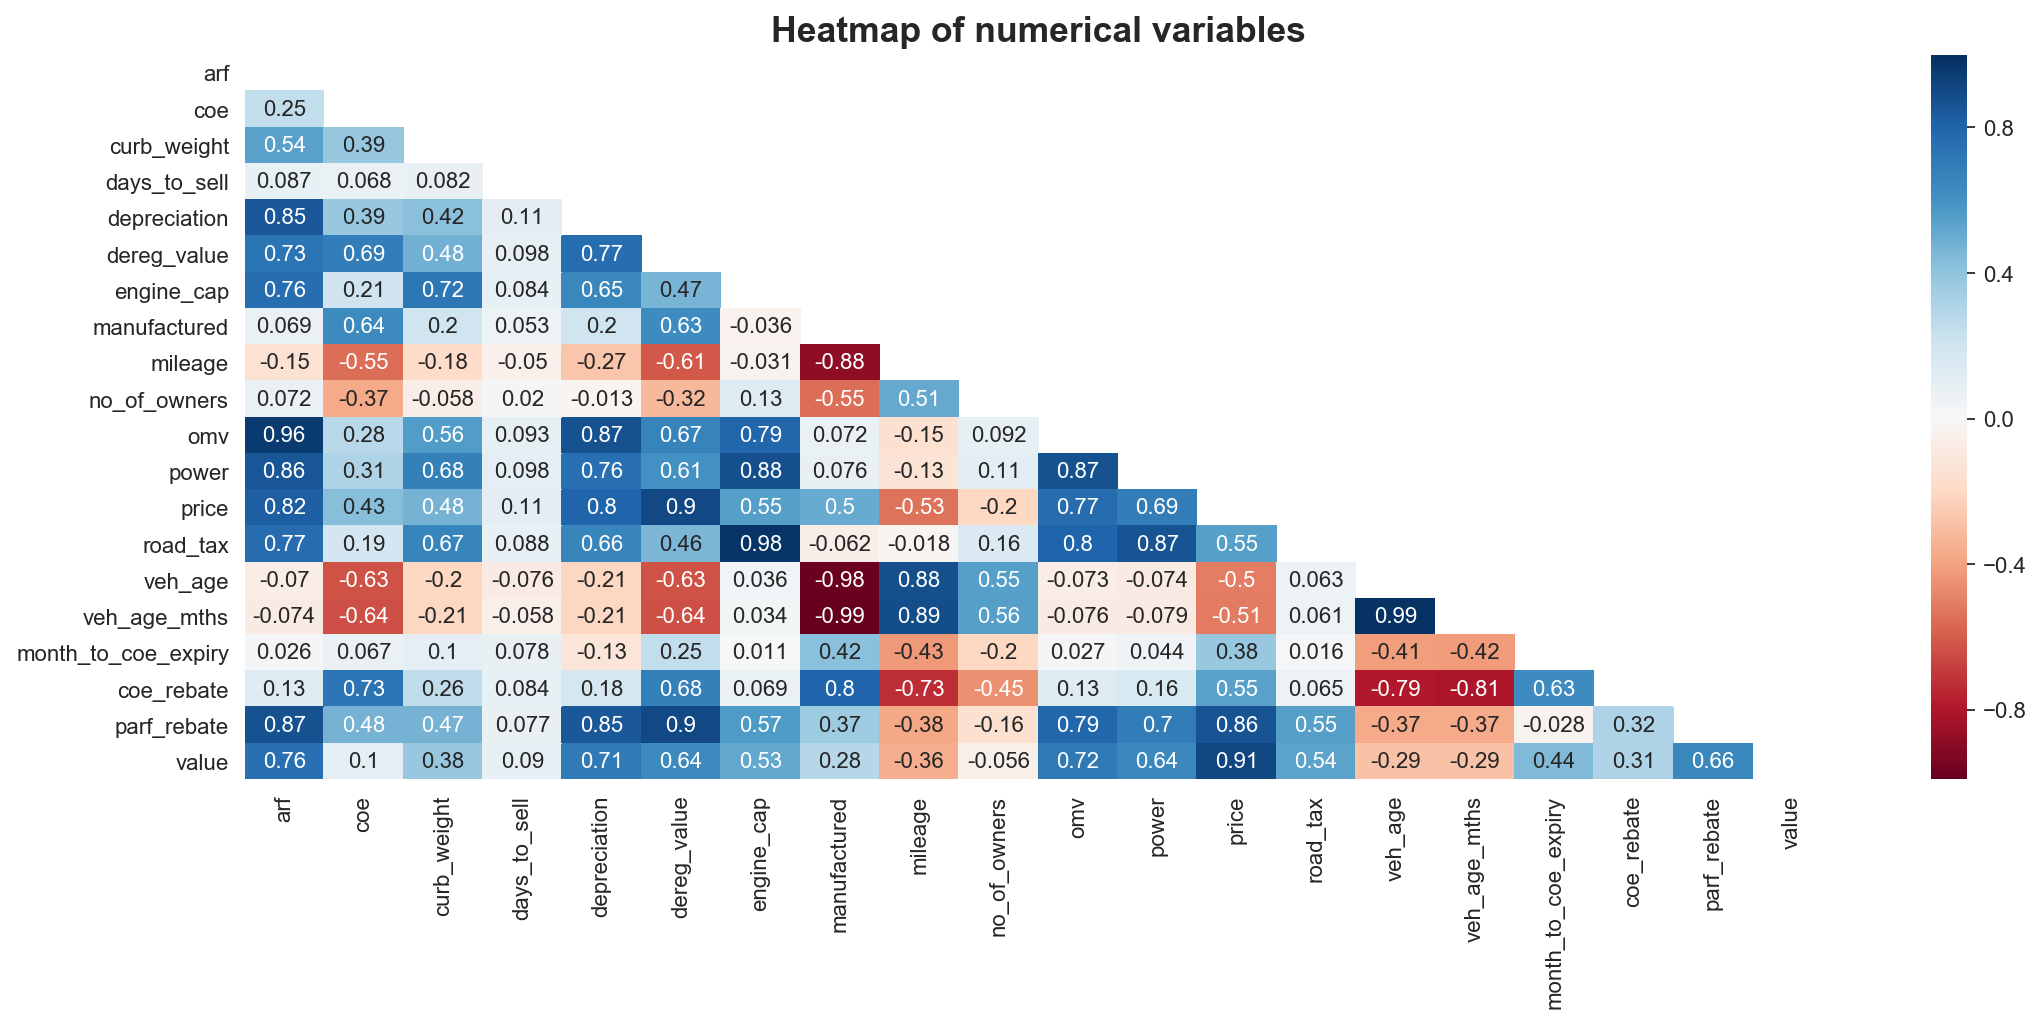

In [40]:

plt.figure(figsize=(16,6), dpi = 80)

corr = cars[num_feats].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax=sns.heatmap(corr,mask=mask,annot=True, cmap='RdBu')
ax.set_title('Heatmap of numerical variables',fontsize=16,fontweight='bold')
plt.show()



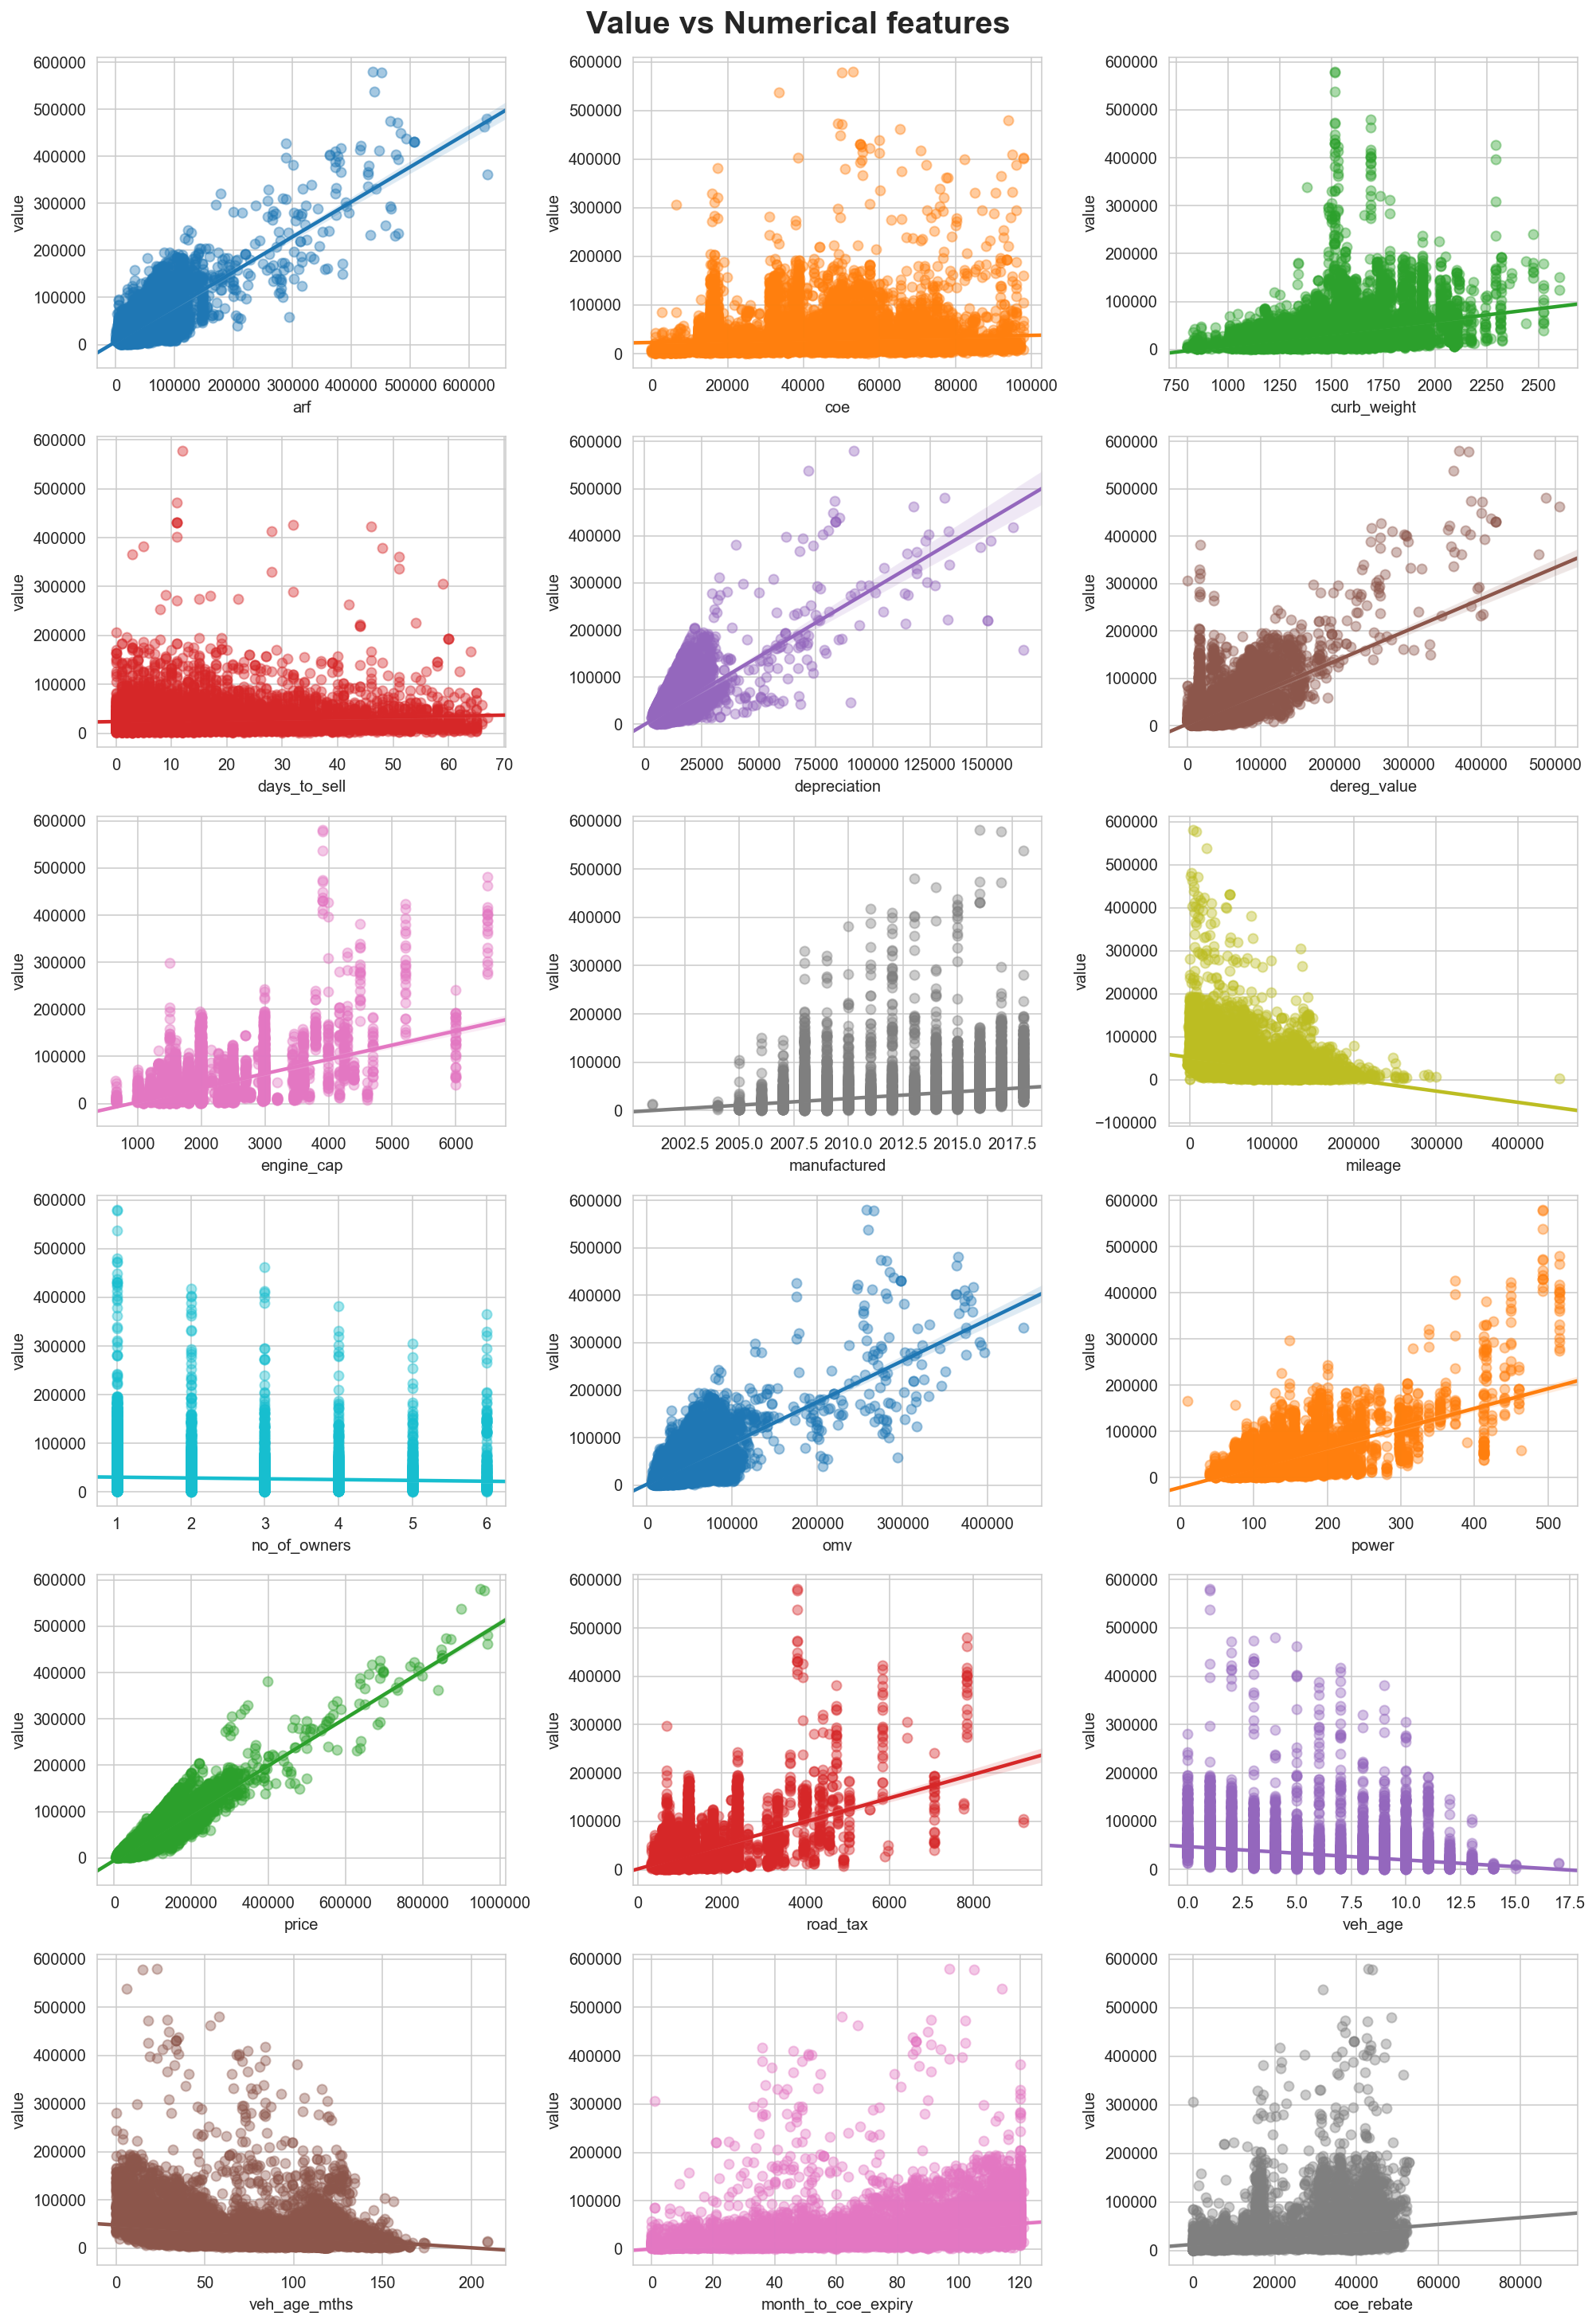

In [41]:
num_feats.remove('value')
f, ax= plt.subplots(6,3,figsize=(14,20))
axes=ax.flatten()

for x,ax in zip(num_feats,axes):
    sns.regplot(x=x,y='value',data=cars,ax=ax,scatter_kws={"alpha": 0.4})
f.suptitle('Value vs Numerical features',fontsize=20,y=1.01,fontweight='bold')
plt.tight_layout()

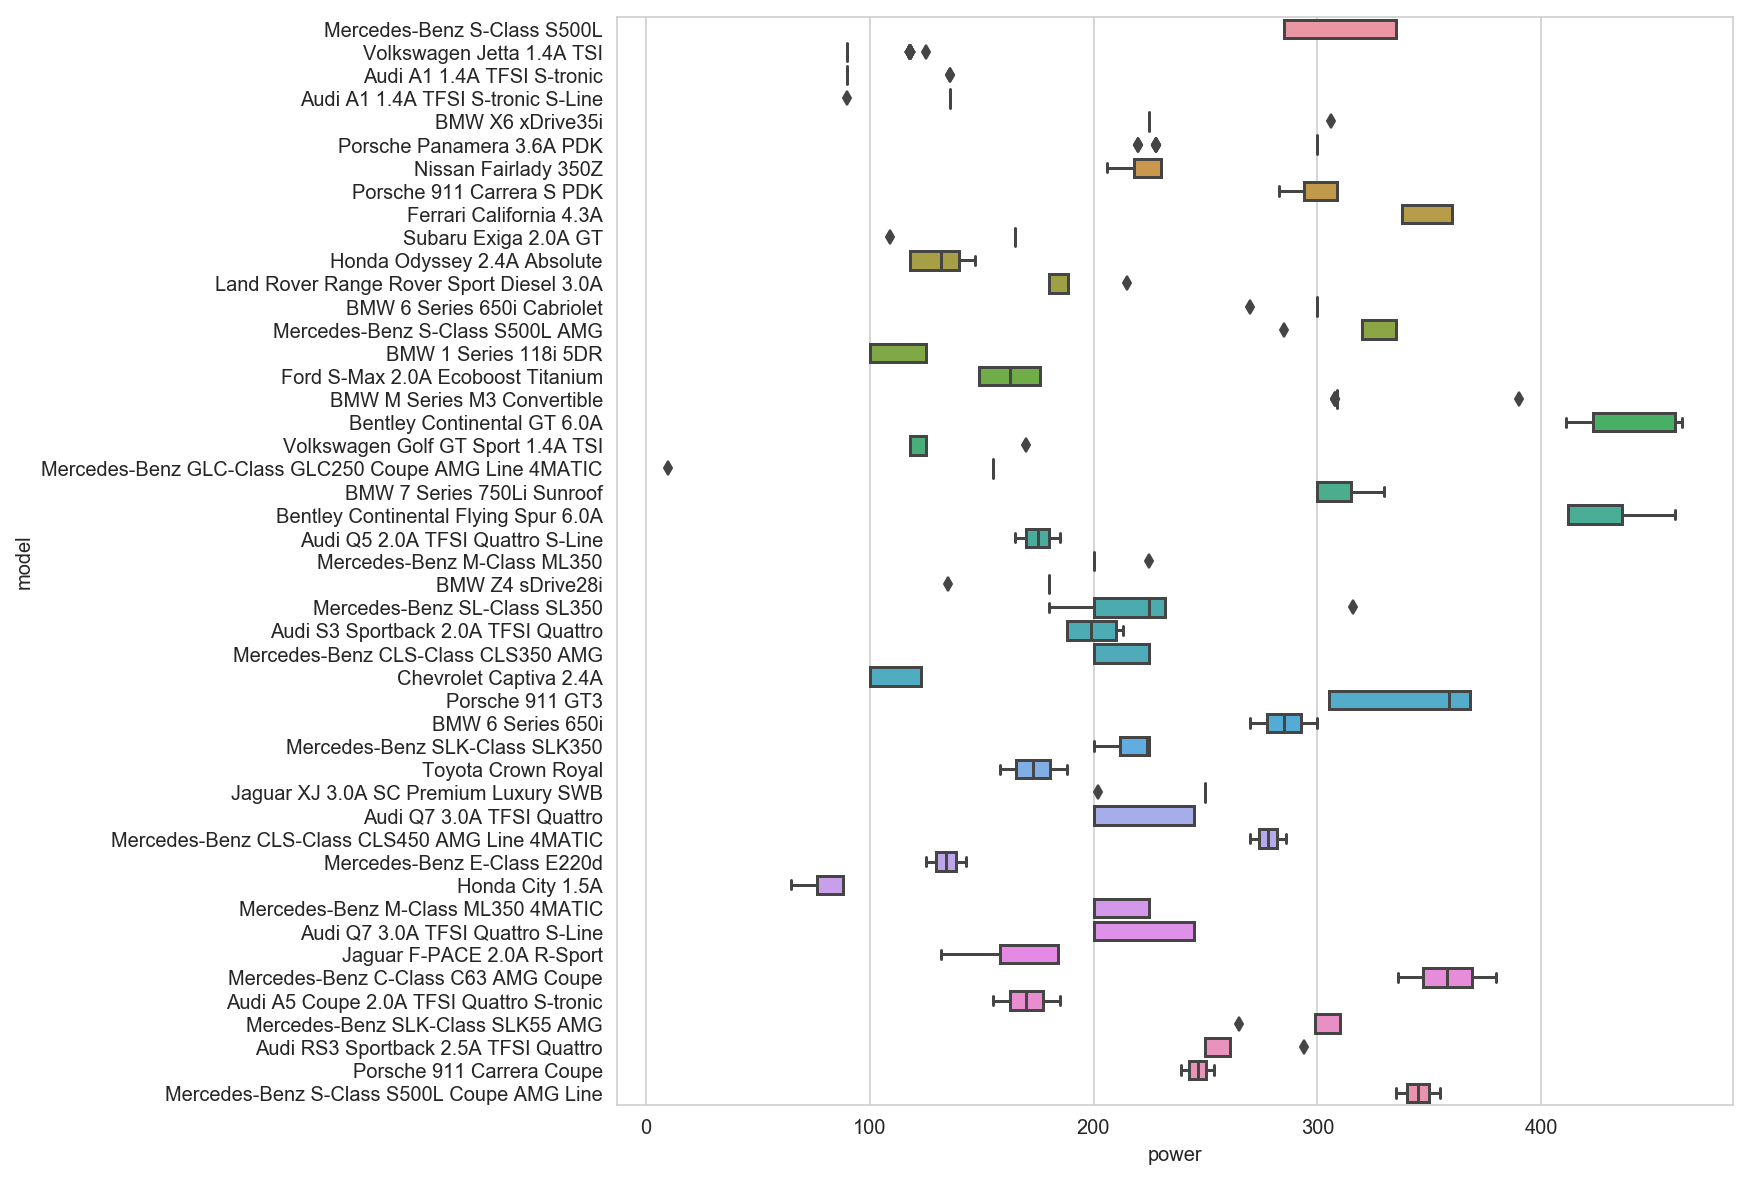

In [42]:
query='''

SELECT power, model 
FROM cars 
WHERE model IN (SELECT model
FROM cars
GROUP BY model
HAVING STDDEV(power) > 10
ORDER BY AVG(power) DESC)


'''

power_df=pd.read_sql_query(query,engine)

plt.figure(figsize=(10,10))
sns.boxplot(x=power_df['power'],y=power_df['model'])

In [43]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [69]:
brand_dums=pd.get_dummies(cars['brand'],prefix='brand_is')
brand_dums.drop(columns='brand_is_Toyota',inplace=True)
fuel_dums=pd.get_dummies(cars['fuel_type'],prefix='fuel_is')
fuel_dums.drop(columns='fuel_is_Diesel',inplace=True)
model_dums=pd.get_dummies(cars['model'],drop_first=True)

In [220]:

X_num=['engine_cap', 'power', 'curb_weight', 'omv', 'mileage', 'veh_age_mths', 'month_to_coe_expiry']
X=pd.concat([cars[X_num],model_dums],axis=1)
y=np.log(cars['value'])

In [176]:
def cross_val_reg(model,name,X,y,scoring=None,folds=5):
    
    '''
        Takes a model, ie. instantiated class object, feature and target set and performs 
        5 fold cross validation using R^2 as a metric.
        
        Prints the scores, mean and std of the scores. 
        
    '''
    print( '------------------------------------\n')
    print('{}-Fold Cross Validated Results for Model: '.format(folds)+ name)
    
    # Compute cross val score # 
    
    scores = cross_val_score(model, X, y, cv=folds,scoring=scoring)
    
    if scoring==None:

        print('Performance Metric: R2')
    else:
        print('Performance Metric: ' + scoring)
        
    print("Cross-validated scores:", scores)
    print("Mean score:", np.mean(scores))
    print('Std score:', np.std(scores))
    
    return np.mean(scores)



In [177]:
Xtrain,Xtest,ytrain,ytest= train_test_split(X,y,random_state=123)


In [178]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import RidgeCV, Ridge, LassoCV, Lasso, ElasticNetCV,ElasticNet

In [230]:
price=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.15, loss='ls', max_depth=6,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=123,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)
price.fit(Xtrain,ytrain)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.15, loss='ls', max_depth=6,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=123,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [179]:
l1=np.linspace(0.05,0.95,num=20)
enetcv=ElasticNetCV(l1_ratio=l1,cv=5,n_jobs=-1)


enetcv.fit(Xtrain,ytrain)

enet=ElasticNet(alpha=enetcv.alpha_,l1_ratio=enetcv.l1_ratio_)
enet.fit(Xtrain,ytrain)



ElasticNet(alpha=0.0005907468107664906, copy_X=True, fit_intercept=True,
      l1_ratio=0.95, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [180]:

ridge_alphas = np.logspace(-2, 7, 50)
ridgecv = RidgeCV(alphas=ridge_alphas, cv=10)

ridgecv.fit(Xtrain,ytrain)

ridge=Ridge(alpha=ridgecv.alpha_)
ridge.fit(Xtrain,ytrain)



Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [181]:
lassocv = LassoCV(n_alphas=500, cv=10)
lassocv.fit(Xtrain,ytrain)

lasso= Lasso(alpha=lassocv.alpha_)
lasso.fit(Xtrain,ytrain)


Lasso(alpha=0.0005612094702281659, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [190]:
rf=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
rf.fit(Xtrain,ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [239]:
cross_val_reg(price,'XGBoost',Xtrain,ytrain,scoring='neg_mean_squared_error')
cross_val_reg(rf,'Random Forest',Xtrain,ytrain,scoring='neg_mean_squared_error')
cross_val_reg(ridge,'Ridge',Xtrain,ytrain,scoring='neg_mean_squared_error')
cross_val_reg(lasso,'Lasso',Xtrain,ytrain,scoring='neg_mean_squared_error')


------------------------------------

5-Fold Cross Validated Results for Model: XGBoost
Performance Metric: neg_mean_squared_error
Cross-validated scores: [-0.11962057 -0.11880429 -0.11329826 -0.13029493 -0.12459178]
Mean score: -0.12132196816562853
Std score: 0.0057414121828280795
------------------------------------

5-Fold Cross Validated Results for Model: Random Forest
Performance Metric: neg_mean_squared_error
Cross-validated scores: [-0.12136724 -0.12077757 -0.11183598 -0.13326443 -0.13127156]
Mean score: -0.12370335414655709
Std score: 0.007791587565423174
------------------------------------

5-Fold Cross Validated Results for Model: Ridge
Performance Metric: neg_mean_squared_error
Cross-validated scores: [-0.14812939 -0.14348462 -0.14082686 -0.1617266  -0.16426243]
Mean score: -0.15168597785888296
Std score: 0.009558379234338844
------------------------------------

5-Fold Cross Validated Results for Model: Lasso
Performance Metric: neg_mean_squared_error
Cross-validated scor

-0.18536088140503712

In [211]:
np.exp(0.18536088140503712)

1.2036527376491717

In [231]:
def cross_val_exp_mse(X,y,model,folds=5):
    mse_=[]
    model.fit(X,y)
    for i in range(folds):
        Xtrain,Xtest,ytrain,ytest=train_test_split(X,y)
        mse=np.sqrt(sum((np.exp(y)-np.exp(model.predict(X)))**2)/X.shape[0]-1)
        mse_.append(mse)
        
    return np.mean(mse_)

print('RMSE for XGB is {}'.format(cross_val_exp_mse(Xtrain,ytrain,price,folds=5)))
print('RMSE for RF is {}'.format(cross_val_exp_mse(Xtrain,ytrain,rf,folds=5)))
print('RMSE for Ridge is {}'.format(cross_val_exp_mse(Xtrain,ytrain,ridge,folds=5)))
print('RMSE for Lasso is {}'.format(cross_val_exp_mse(Xtrain,ytrain,lasso,folds=5)))

RMSE for XGB is 6653.853701859759
RMSE for RF is 4494.889112184826
RMSE for Ridge is 10955.679280628148
RMSE for Lasso is 18036.24252490052


In [221]:
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [225]:

def residual_plot(model,name,X,y,color):
    '''
        Takes a model, its name and 
    '''

    
    # Generate reisduals #
    preds=model.predict(X)
    resids=y-preds

    
    # Plot reisduals vs y first # 
    
    ax=sns.scatterplot(preds,resids,alpha=0.2,color=color)
    
    # Add y=0 line # 
    uplim=max(ax.get_xlim())
    lowlim=min(ax.get_xlim())
    lines=np.linspace(lowlim,uplim)
    zeros=np.zeros(50)
    plt.plot(lines,zeros,linestyle='--')
    
    # Set title # 
    ax.set_title(name,fontsize=12)
    
    # Set labels # 
    ax.set_ylabel('Residuals')
    ax.set_xlabel('Predicted')

    

def act_pred_plots(model,name,X,y,color):
    '''
        Takes a model, its name, feature set and predictor set and returns an actual vs predicted plot
    '''

    # Generate predictions #
    preds=model.predict(X)
    
    # Plot reisduals vs y first # 

    ax=sns.scatterplot(preds,y,alpha=0.2,color=color)

    
    # Make it a square plot # 
    uplim=max(ax.get_xlim()+ax.get_ylim())
    lowlim=min(ax.get_xlim()+ax.get_ylim())
    ax.set_xlim(lowlim,uplim)
    ax.set_ylim(lowlim,uplim)
    
    # Add unit line # 
    lines=np.linspace(lowlim,uplim)
    plt.plot(lines,lines,linestyle='--')
    # Set title # 
    ax.set_title(name,fontsize=12)
    
    # Set axis labels # 

    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

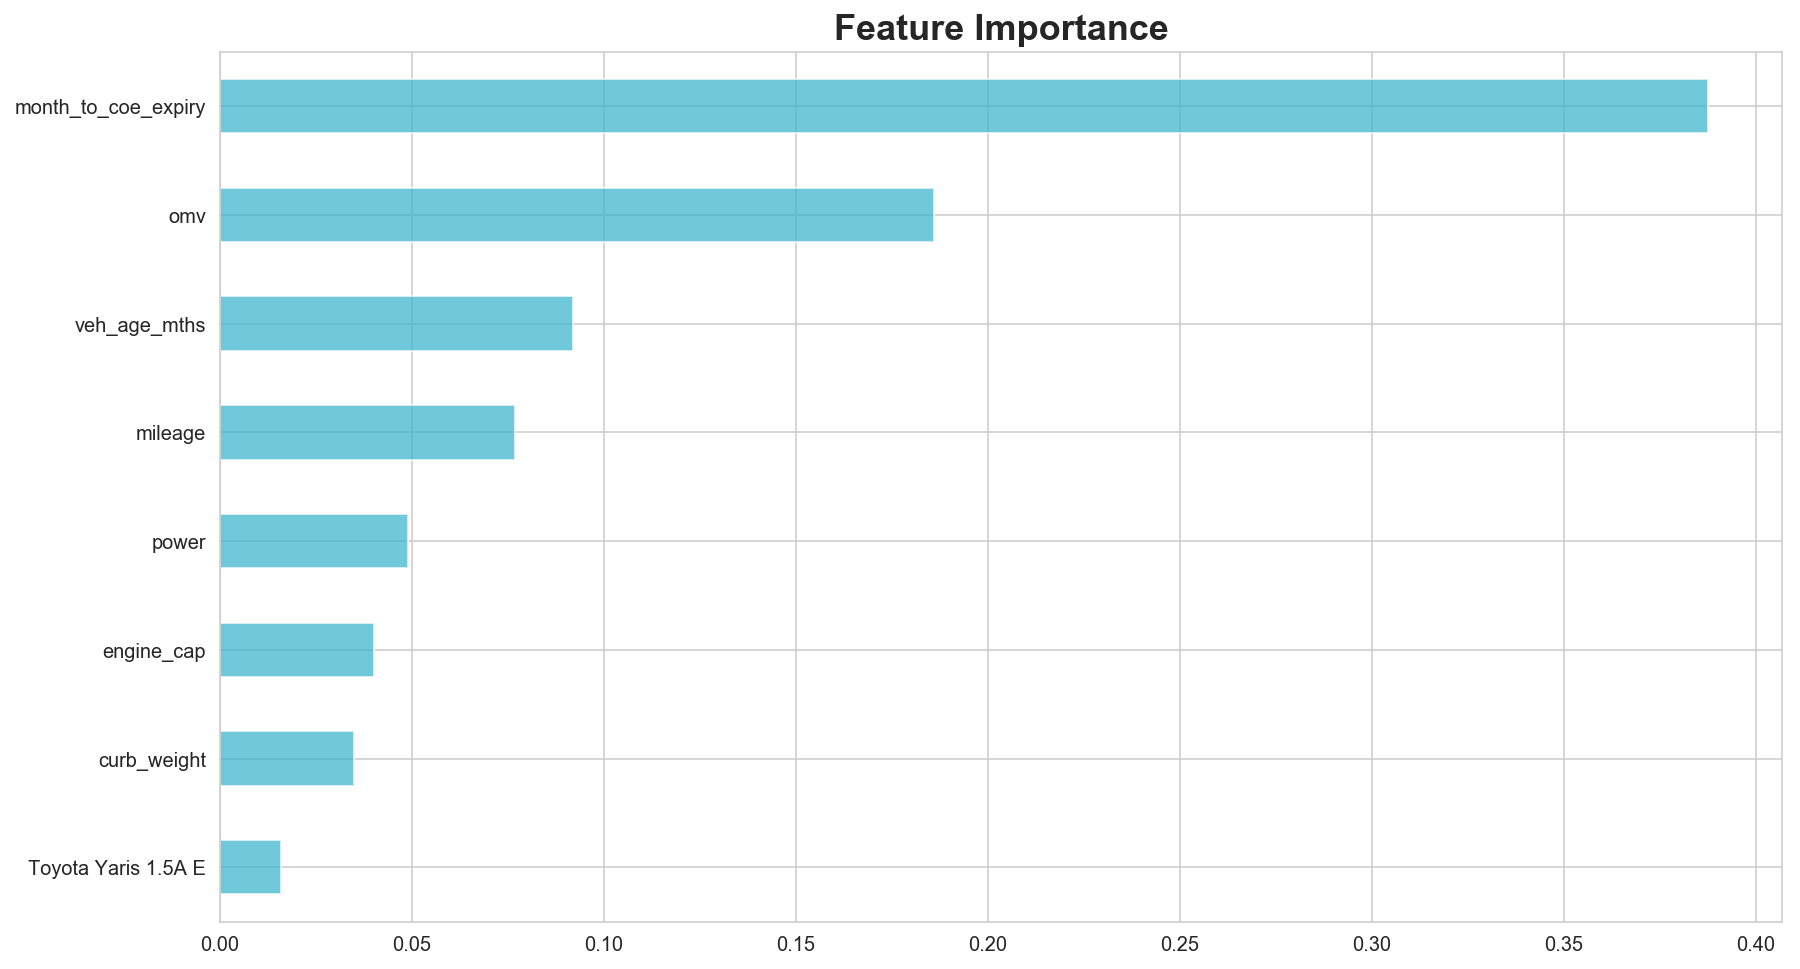

In [202]:
rfr_feats=pd.DataFrame({'variable':X.columns,
 'feature_importance':price.feature_importances_})

rfr_feats.sort_values(by='feature_importance',inplace=True)
f=plt.figure(figsize=(14,8))

# Look at features which have importance above >0.01 # 
ax=rfr_feats['feature_importance'][rfr_feats['feature_importance']>0.01].plot.barh(color=(0.2,0.7,0.8),alpha=0.7)
ax.set_yticklabels(rfr_feats['variable'][rfr_feats['feature_importance']>0.01])
ax.set_title('Feature Importance',fontsize=18,fontweight='bold')
plt.show()

In [178]:
# Generate new covariance matrix and residual error # 

preds=xgbr.predict(X_2)
resids=Y-preds
var=np.sum([resid**2 for resid in resids])/(X_2.shape[0]-X_2.shape[1])
cov=np.linalg.inv(np.dot(X_2.T,X_2))

np.save('./flask/cov.npy',np.linalg.inv(np.dot(X_2.T,X_2)))
np.save('./flask/residual_error.npy',np.sum([resid**2 for resid in resids])/(X_2.shape[0]-X_2.shape[1]))

In [235]:
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

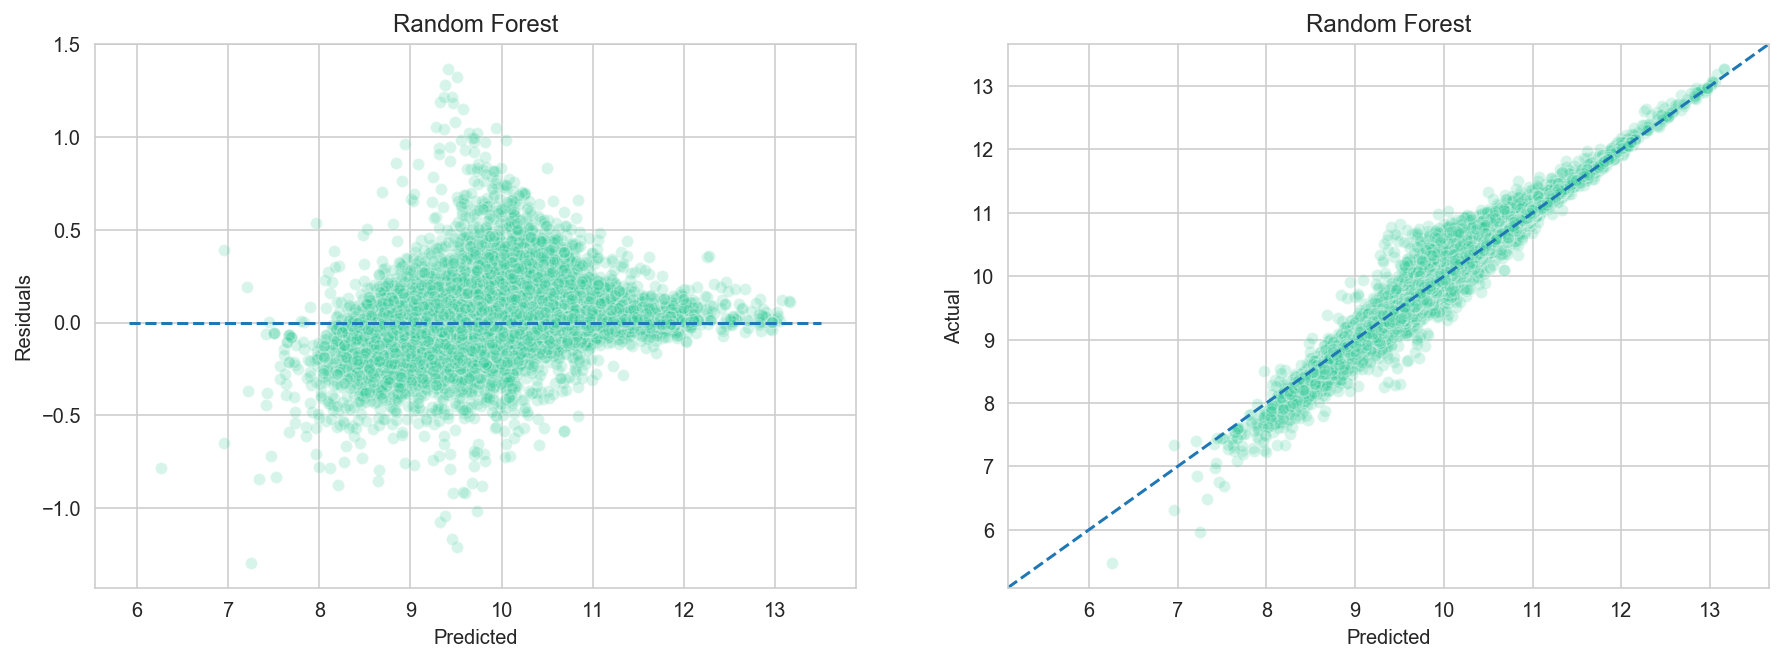

In [236]:
plt.figure(figsize=(15,5))
plt.subplot(121)
residual_plot(rf,"Random Forest",X,y,color=(0.2,0.8,0.6))
plt.subplot(122)
act_pred_plots(rf,"Random Forest",X,y,color=(0.2,0.8,0.6))

plt.show()




In [237]:
price.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.15, loss='ls', max_depth=6,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=123,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

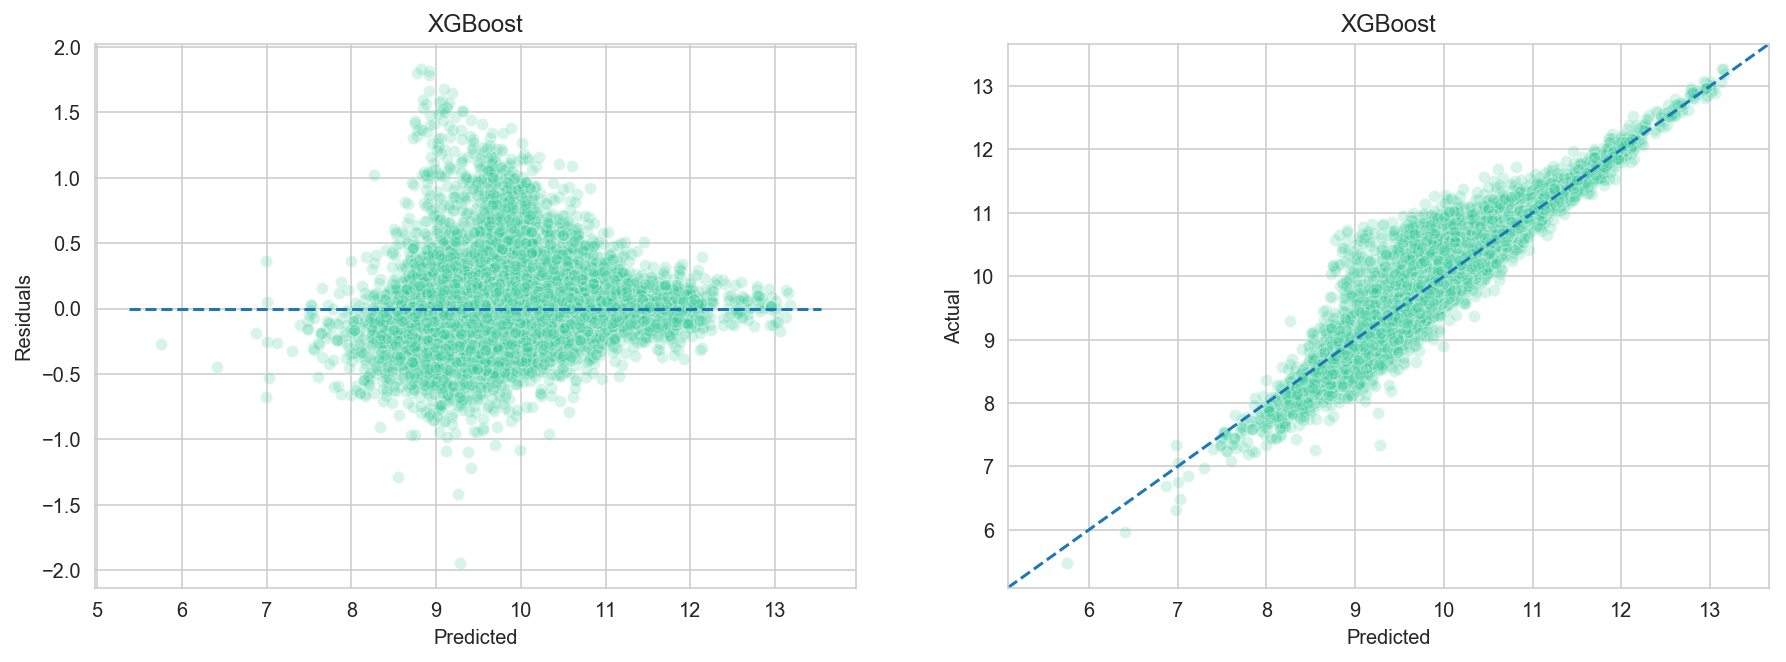

In [238]:
plt.figure(figsize=(15,5))
plt.subplot(121)
residual_plot(price,"XGBoost",X,y,color=(0.2,0.8,0.6))
plt.subplot(122)
act_pred_plots(price,"XGBoost",X,y,color=(0.2,0.8,0.6))

plt.show()


In [31]:
from sklearn.externals import joblib
price_model=joblib.load('./flask/PRICE.pkl')

In [40]:
price_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.15, loss='ls', max_depth=6,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             n_iter_no_change=None, presort='auto', random_state=123,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [36]:
price_model.predict(X_2)

(21394,)

In [37]:
from sklearn.linear_model import LinearRegression

Text(0.5, 0, 'XGBoost')

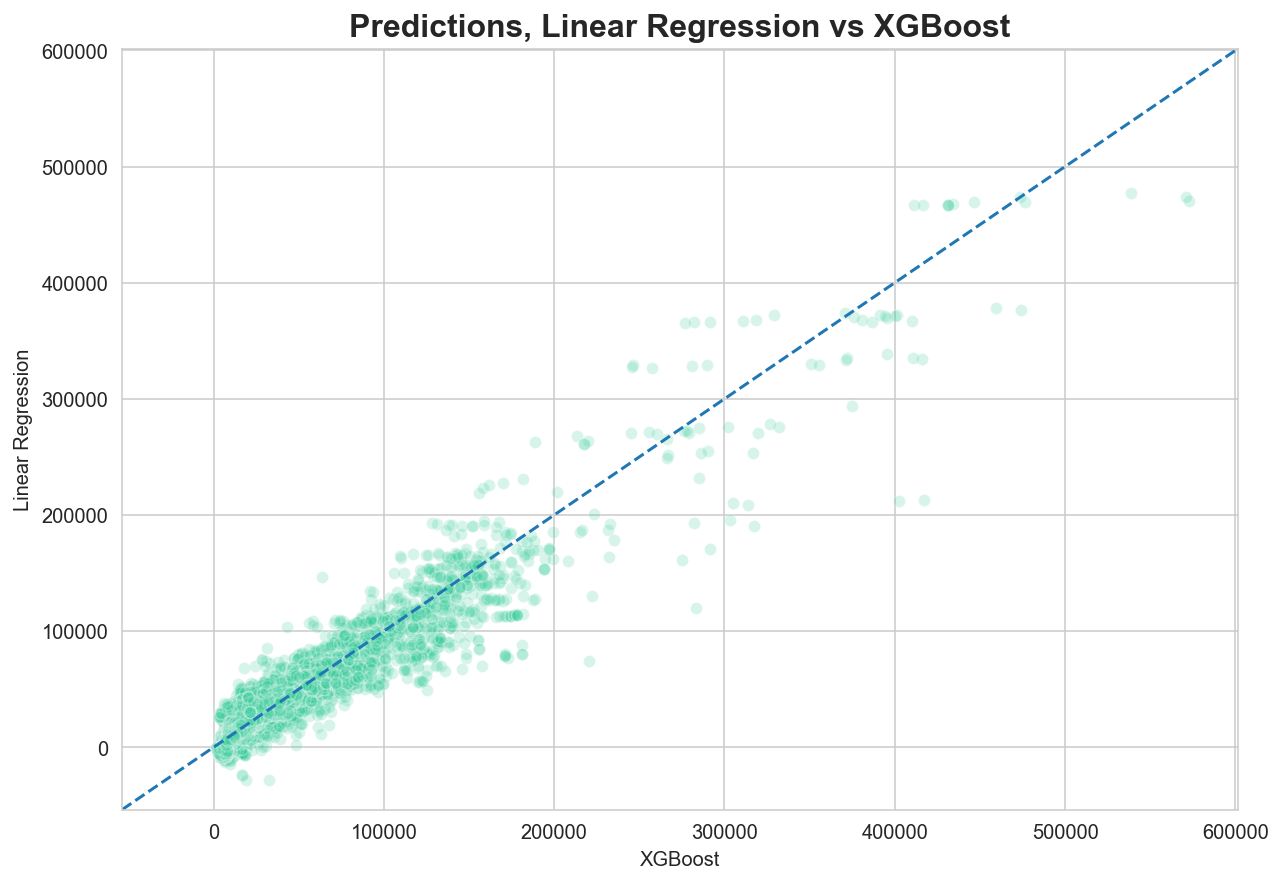

In [47]:
plt.figure(figsize=(10,7))
# Generate predictions #
m1=price_model.predict(X_2)
m2=lr.predict(X_2)

# Plot reisduals vs y first # 

ax=sns.scatterplot(m1,m2,alpha=0.2,color=(0.2,0.8,0.6))


# Make it a square plot # 
uplim=max(ax.get_xlim()+ax.get_ylim())
lowlim=min(ax.get_xlim()+ax.get_ylim())
ax.set_xlim(lowlim,uplim)
ax.set_ylim(lowlim,uplim)

# Add unit line # 
lines=np.linspace(lowlim,uplim)
plt.plot(lines,lines,linestyle='--')
# Set title # 
ax.set_title("Predictions, Linear Regression vs XGBoost",fontsize=16,fontweight='bold')

# Set axis labels # 

ax.set_ylabel('Linear Regression')
ax.set_xlabel('XGBoost')

In [77]:
price=joblib.load('./flask/PRICE.pkl')